## Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import custom statistic functions
import tcga_plots

#location of figshare fig4
figshare_dir = './'
#where to find projected PTMs
panel_save_dir = './FigurePanels/'
sfig_save_dir = './SupplementalFigures/'
table_save_dir = './/Manuscript/'

tcga_data = tcga_plots.TCGA_Data(figshare_dir)

Number of ESRP1 low patients: 61 (12.5%))
Number of ESRP1 high patients: 68 (13.93%)


Breakdown of planned figure
1. Main Figure: We want to show total ptms captured, functional implications of these changes at Gene,exon and PTM level, how it impacts regulatory enzymes like kinases, then the final TSC2/SGK story to wrap things up
    1. Heatmap summarizing PTMs captured
    2. Fraction of splice events involving PTMs (include PTM types?)
    2. Select Enrichr Results
    3. Select Exon Ontology Results (combine with 2?)
    4. If relevant, matching PTM annotation results
    5. Kinase substrate enrichment
    6. Segway into TSC2/SGK?
    7. PTEN/ESRP1 survival plot
    8. Signaling diagram
2. Supplements:
    1. Summary of captured PTMs: overlap with Yang and other dataset, modification type breakdown, enriched functions
    2. All gene set enrichment results + All exon ontology results
    3. Extra kinase substrate info

### Breakdown of events

In [65]:
tcga_data.print_breakdown()

Within PRAD, 8262 genes have 130449 exons and 560 have significant exon inclusion changes (0.61%).
Among these exons, there are 223298 PTMs and 1125 have significant changes (0.5%). 197 genes have significant PTM changes.
In addition, 108 genes have altered PTMs without significant PTM inclusion changes. This includes a total of 286 exons and 364 PTMs.


In [66]:
tcga_data.print_exon_containing_ptm_info()

Number of spliced exons with PTMs: 276
Fraction of spliced exons with PTMs: 0.5257142857142857


In [235]:
if not hasattr(tcga_data, 'total_controlled_exons'):
    tcga_data.breakdown_events()
print(f'Number of PTMs with differential exon inclusion: {len(tcga_data.total_controlled_ptms)} ({round((len(tcga_data.total_controlled_ptms)/len(tcga_data.total_ptms))*100, 2)}%)')
print('Of these, {} are in the low group and {} are in the high group'.format(tcga_data.sig_ptms.loc[tcga_data.sig_ptms['ESRP1_MW'] == 'Low', 'PTM'].nunique(), tcga_data.sig_ptms.loc[tcga_data.sig_ptms['ESRP1_MW'] == 'High', 'PTM'].nunique()))
print(f"{len(tcga_data.total_genes_with_controlled_exons)} of genes ({round((len(tcga_data.total_genes_with_controlled_exons)/len(tcga_data.total_genes))*100,2)})% in the dataset are associated with specific splice events,\n {len(tcga_data.total_genes_with_controlled_ptms) + len(tcga_data.total_genes_with_altered_ptms_only)} of which are associated with impacted PTMs ({round((len(tcga_data.total_genes_with_controlled_ptms) + len(tcga_data.total_genes_with_altered_ptms_only))/len(tcga_data.total_genes_with_controlled_exons)*100,2)}%)")
yang_data_dir = tcga_data.analysis_dir + "/Yang2016/"
if yang_data_dir is not None:
    yang = pd.read_csv(yang_data_dir + '/spliced_ptms_Yang2016.csv')
    yang_ptms = yang.apply(lambda x: x['UniProtKB Accession'] + '_' + x['Residue']+ str(int(float(x['PTM Position in Canonical Isoform']))) if x['PTM Position in Canonical Isoform'] == x['PTM Position in Canonical Isoform'] else x['Source of PTM'].split(';')[0], axis = 1)
    intersection = set(tcga_data.sig_ptms['PTM'].values).intersection(set(yang_ptms))
    print(f'{len(intersection)} of identified PTMs overlap with PTMs previously identified by Yang et al.')

print(f'{len(tcga_data.total_ptms_with_altered_flanks)} PTMs have altered flanking sequences ({round((len(tcga_data.total_ptms_with_altered_flanks)/len(tcga_data.total_ptms))*100, 2)}%)')
print(f'In sum, {len(tcga_data.total_ptms_with_altered_flanks)+len(tcga_data.total_controlled_ptms)} different PTM sites across {len(tcga_data.total_controlled_exons_with_ptms)+len(tcga_data.total_controlled_exons_with_altered_flanks_only)} different exons were impacted by differences in ESRP1 expression')

#print(f'{} and {} differentially included PTMs have been associated with molecular association and intracellular localizaiton, respectively')
if not hasattr(tcga_data, 'interactions'):
    tcga_data.interactions = pd.read_csv(tcga_data.analysis_dir + '/TCGA/PTM_interactions.csv')
    tcga_data.interactions['Regulation Change'] = tcga_data.interactions.apply(lambda x: 1 if x['Type'] != 'DISRUPTS' and x['deltaPSI_MW'] > 0 else 1 if x['Type'] == 'DISRUPTS' and x['deltaPSI_MW'] < 0 else -1, axis = 1)
full_network = tcga_data.interactions.drop_duplicates(subset = ['Modified Gene', 'Interacting Gene'])
sig_network = tcga_data.interactions.dropna(subset = 'deltaPSI_MW').drop_duplicates(subset = ['Modified Gene', 'Interacting Gene'])


print(f'{sig_network.shape[0]} PTM-associated interactions are impacted by ESRP1 mediated splicing out of {full_network.shape[0]} total possible interactions')

sig_annot = tcga_data.annotated_ptms.loc[tcga_data.annotated_ptms['Source of PTM'].isin(tcga_data.sig_ptms['Source of PTM'])]
frac_unstruct = sig_annot[sig_annot['EXONT:Name'].apply(lambda x: 'unstructured' in x if x == x else False)].shape[0]/sig_annot.shape[0]
print(f'{round(frac_unstruct*100,2)}% of differentially included PTMs are associated with exons in unstructured regions')

Number of PTMs with differential exon inclusion: 1125 (0.5%)
Of these, 476 are in the low group and 649 are in the high group
560 of genes (6.78)% in the dataset are associated with specific splice events,
 305 of which are associated with impacted PTMs (54.46%)
107 of identified PTMs overlap with PTMs previously identified by Yang et al.
364 PTMs have altered flanking sequences (0.16%)
In sum, 1489 different PTM sites across 562 different exons were impacted by differences in ESRP1 expression
487 PTM-associated interactions are impacted by ESRP1 mediated splicing out of 25510 total possible interactions
59.12% of differentially included PTMs are associated with exons in unstructured regions


## Figure 4

In [125]:
fig4 = tcga_plots.Figure4(tcga_data)

### Panel A, heatmap

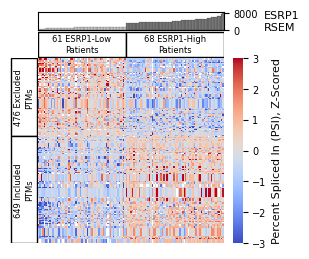

In [68]:
fig4.PanelA(save_panel_dir = panel_save_dir)

### Panel B, Summary Pie

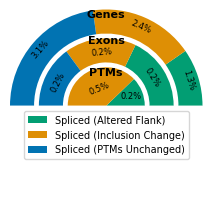

In [70]:
fig4.PanelB(save_panel_dir = panel_save_dir)

### Panel C, Enrichr Results

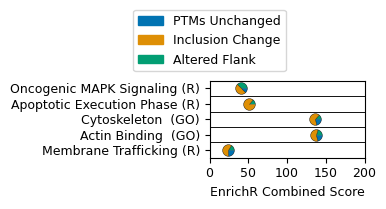

In [71]:
fig4.PanelC(save_panel_dir = panel_save_dir, type = 'circle', edgecolor = 'black')

### Panel D, Exon Ontology Results

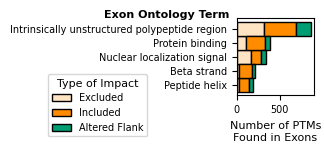

In [72]:
fig4.PanelD(save_panel_dir = panel_save_dir)

### Panel E, PTM Interactions

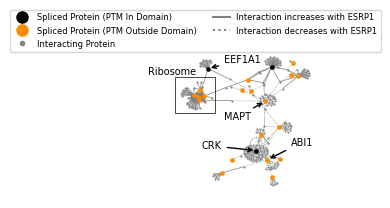

In [185]:
fig4.PanelE_Network(save_panel_dir=panel_save_dir,in_domain_marker = 'o', in_domain_edge = 'black', out_domain_edge = None, in_domain_color = 'black', out_domain_color = 'darkorange', larger_marker = 10)

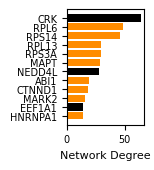

In [184]:
fig4.PanelE_Degree(save_panel_dir=panel_save_dir,in_domain_color = 'black', out_domain_color = 'darkorange')

In [135]:
frac_ptm_in_domain  = fig4.TCGA_data.interactions[fig4.TCGA_data.interactions['In Domain']].shape[0]/fig4.TCGA_data.interactions.shape[0]
tmp = fig4.TCGA_data.interactions.copy()
tmp = tmp.groupby(["Modified Gene", 'Interacting Gene'])['In Domain'].sum()
frac_int_with_domain = tmp[tmp >0].shape[0]/tmp.shape[0]
print(f"{frac_int_with_domain*100:.2f}% of interactions have at least one PTM in the domain")
print(f"{frac_ptm_in_domain*100:.2f}% of all interacting PTMs fall within domains")

49.98% of interactions have at least one PTM in the domain
20.12% of all interacting PTMs fall within domains


### Panel F, Sh2 domain motifs

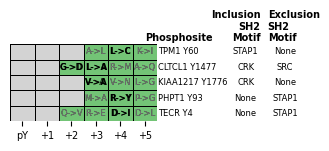

In [501]:
fig4.PanelF(save_panel_dir=panel_save_dir, elm_data_file = '../../../../Database_Information/ELM/elm_classes.tsv')

## Figure 5

In [ ]:
fig5 = tcga_plots.Figure5(tcga_data)

### Panel A, Known substrates

In [ ]:
fig5.PanelA(save_panel_dir=panel_save_dir)

### Panel B, KSTAR

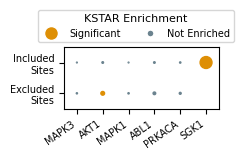

In [145]:
fig5.PanelB(save_panel_dir=panel_save_dir)

### Panel C, Kinase Library

In [ ]:
fig5.PanelC(save_panel_dir=panel_save_dir)

### Panel D, TSC2

c:\Users\Sam\OneDrive\Documents\GradSchool\Research\Splicing\Paper_Prep\PTM_Splicing_Analysis\PaperFigures\tcga_plots.py:1310: DtypeWarning: Columns (1005) have mixed types. Specify dtype option on import or set low_memory=False.
  breast = pd.read_csv(self.tcga_data.analysis_dir + '/TCGA/PSI_ptms_Breast.csv')


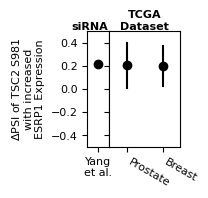

In [192]:
fig5.PanelD(save_panel_dir=panel_save_dir)

### Panel J, PTEN/ESRP1

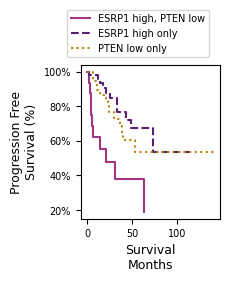

In [154]:
palette = sns.color_palette('dark')
colors = [palette[6], palette[4], palette[8]]
fig5.PanelE(leg_loc = (-0.1, 1.05), colors = colors, save_panel_dir = panel_save_dir)

## Supplements

### Supplementary Figure 12 (Summary of PTMs)

In [193]:
sfig12 = tcga_plots.SupplementaryFigure12(tcga_data)

### Panel A, PTMs included or excluded

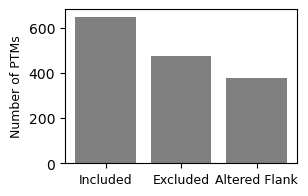

In [224]:
sfig12.PanelA(panel_save_dir = panel_save_dir)

### Panel B, PTM types

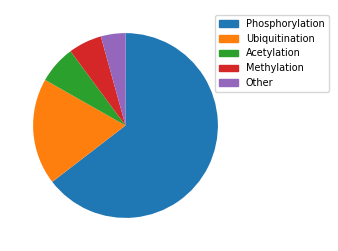

In [225]:
sfig12.PanelB(panel_save_dir = panel_save_dir)

### Panel C, Overlap with Knockdown

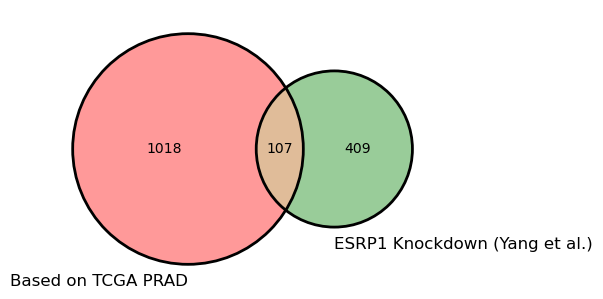

In [194]:
sfig12.PanelC(yang_data_dir = tcga_data.analysis_dir + "/Yang2016/", panel_save_dir = panel_save_dir)

## Supplementary Figure 13 (Gene Set Enrichment)

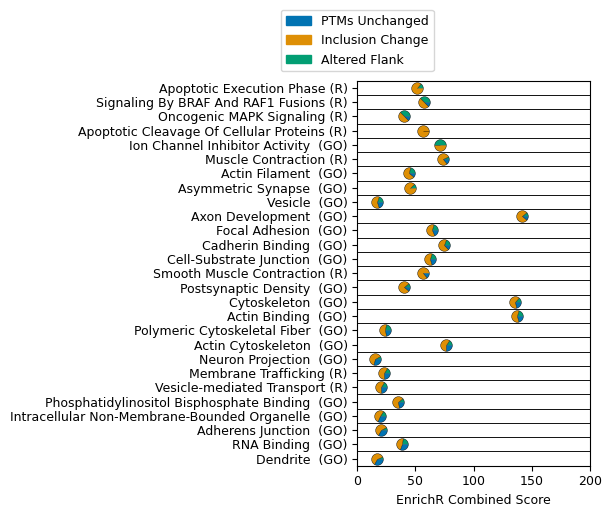

In [227]:
sfig13 = tcga_plots.SupplementaryFigure13(tcga_data)
sfig13.create_figure(save_dir = sfig_save_dir)

## Supplementary Figure 14 (PTM-associated annotations)

In [364]:
sfig14 = tcga_plots.SupplementaryFigure14(tcga_data)

### Panel A, Exon Ontology

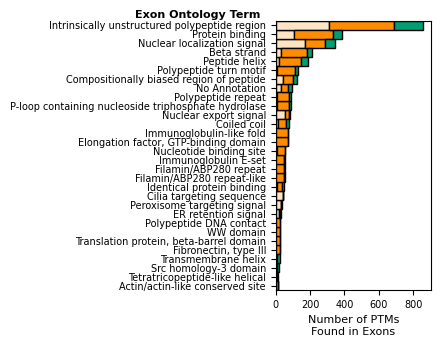

In [229]:
sfig14.PanelA(save_panel_dir = panel_save_dir)

### Panel B, Biological Process

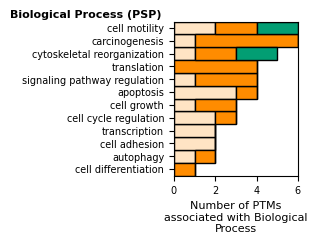

In [230]:
sfig14.PanelB(save_panel_dir = panel_save_dir)

### Panel C, Molecular Function

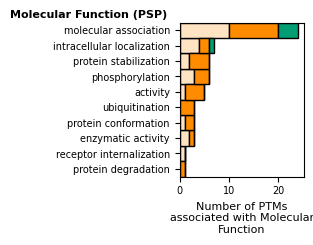

In [231]:
sfig14.PanelC(save_panel_dir = panel_save_dir)

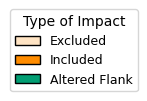

In [232]:
#legend
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize = (1,1))
handles = [mpatches.Patch(facecolor = fig4.bar_colors[0], edgecolor = 'black', label = 'Excluded'), mpatches.Patch(facecolor = fig4.bar_colors[1], edgecolor = 'black', label = 'Included'),mpatches.Patch(facecolor = fig4.bar_colors[2], edgecolor = 'black', label = 'Altered Flank')]
ax.legend(handles = handles, ncol = 1, loc = 'center', fontsize = 9, title = 'Type of Impact', title_fontsize = 10)
ax.axis('off')
plt.savefig(panel_save_dir + 'SFig14_Legend.svg', bbox_inches = 'tight', dpi = 300)

## Supplementary Figure 15 (Interactions)

In [79]:
importlib.reload(tcga_plots)

<module 'tcga_plots' from 'c:\\Users\\Sam\\OneDrive\\Documents\\GradSchool\\Research\\Splicing\\Paper_Prep\\PTM_Splicing_Analysis\\PaperFigures\\tcga_plots.py'>

In [80]:
sfig15 = tcga_plots.SupplementaryFigure15(tcga_data)

### Panel A, Network Degree

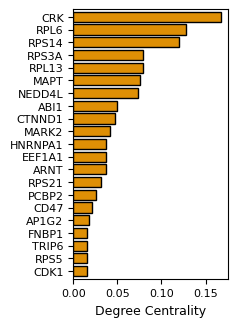

In [77]:
sfig15.PanelA(save_panel_dir = panel_save_dir)

### Panel B, Betweenness


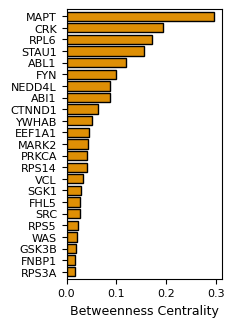

In [81]:
sfig15.PanelB(save_panel_dir = panel_save_dir)

### Panel C, SRC/ABL interacting proteins

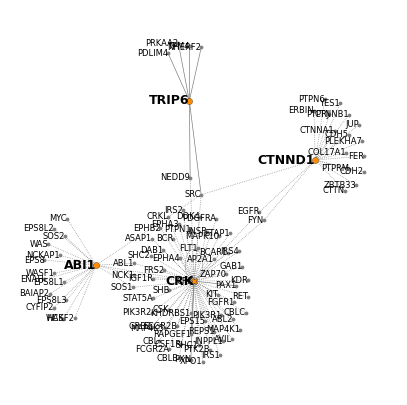

In [82]:
sfig15.PanelC(save_panel_dir = panel_save_dir)

### Panel D, Ribosomal Network

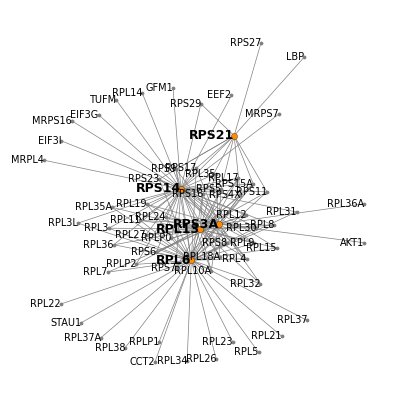

In [83]:
sfig15.PanelD(save_panel_dir = panel_save_dir)

## Supplementary Figure 16 (Motif Changes)

In [422]:
sfig16 = tcga_plots.SupplementaryFigure16(tcga_data)

### Panel A, Modification Breakdown

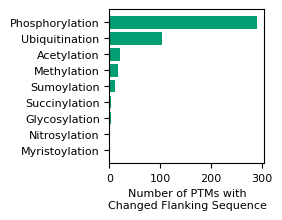

In [6]:

sfig16.PanelA(save_panel_dir = panel_save_dir)

### Panel B, Sequence Similarity

In [417]:
importlib.reload(tcga_plots)
sfig16 = tcga_plots.SupplementaryFigure16(tcga_data)

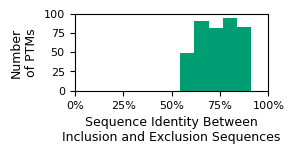

In [418]:
sfig16.PanelB(save_panel_dir = panel_save_dir)

#### Panel C, Position of Changes

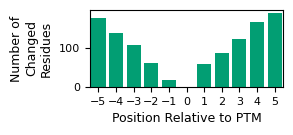

In [419]:
sfig16.PanelC(save_panel_dir = panel_save_dir)

### Panel D

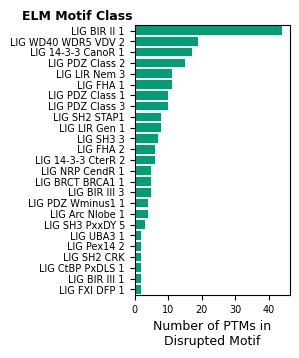

In [5]:
sfig16.PanelD(elm_data_file = '../../../../Database_Information/ELM/elm_classes.tsv', save_panel_dir = panel_save_dir)

### Panel E

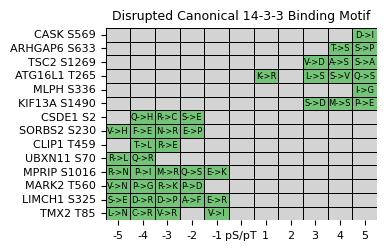

In [51]:
sfig16.PanelE(save_panel_dir = panel_save_dir)

## Supplementary Figure 17 (Kinase Substrate Information)

In [67]:
sfig17 = tcga_plots.SupplementaryFigure17(tcga_data)

### Panel A, Known KS

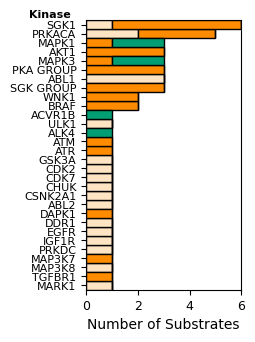

In [58]:
sfig17.PanelA(save_panel_dir = panel_save_dir)

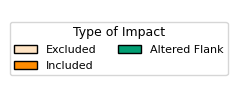

In [62]:
sfig17.PanelA_legend(save_panel_dir = panel_save_dir)

### Panel B, KSTAR

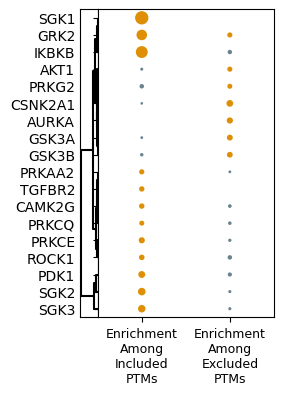

In [63]:
sfig17.PanelB(save_panel_dir = panel_save_dir)

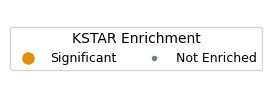

In [64]:
sfig17.PanelB_Legend(save_panel_dir = panel_save_dir)

#### Panel C, SGK1 Substrates

In [ ]:
sfig17.PanelC(save_panel_dir = panel_save_dir)

## Supplementary Table 3

In [265]:
stable3 = tcga_plots.SupplementaryTable3(tcga_data)
stable3.create_worksheet(save_dir = table_save_dir)